# Eistee-Tribunal: Die Auswertung

In [44]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')

In [45]:
# reading the data
basePath = Path().resolve() / "tribunalDaten/"
dataPath = basePath / "eisteeTribunal.csv"
labelPath = basePath / "tea-id.csv"
plotPath = basePath / "plots"

raw_data = pd.read_csv(dataPath)
labels = pd.read_csv(labelPath, delimiter=";")

# calculate price rating
labels['price_pfand'] = labels.apply(lambda row: (row['Price'] + row['Pfand']) / row["Size(l)"], axis=1)
labels['price_no_pfand'] = labels.apply(lambda row: row['Price'] / row["Size(l)"], axis=1)

price_min = labels['price_pfand'].min()
price_max = labels['price_pfand'].max()

# put price on 10 point scale
labels['Preis'] = labels.apply(lambda row: 10 - ((row['price_pfand'] - price_min) / (price_max - price_min)) * 9, axis=1)


In [46]:
judges = raw_data["Tester"].unique()
judges_colors = [ "#c9a548", "#3a8368", "#4e7f36", "#b26030", "#c3494c" ]

categories = list(raw_data.columns)
teas = labels["Name"].unique()
print("Kategorien: ", categories)

for category in ['Tester', 'Tea-ID', 'Geruch', 'I']:
    categories.remove(category)
categories.append("Preis")
print("Tester: ", judges)
print("Kategorien: ", categories)
print("Eistee-Sorten", teas)


Kategorien:  ['Tester', 'Tea-ID', 'Geruch', 'Geschmack', 'Nachgeschmack', 'Freshness', 'Mundgefühl', 'Overall Niceness', 'I']
Tester:  ['Yeelix' 'Lenni' 'Marco' 'MaxW' 'MaxN']
Kategorien:  ['Geschmack', 'Nachgeschmack', 'Freshness', 'Mundgefühl', 'Overall Niceness', 'Preis']
Eistee-Sorten ['Lipton' 'Edeka Premium' 'Arizona' 'FuzeTea' 'Ti' 'Pfanner'
 'Richards Sun' 'Rauch' 'Volvic' 'Aldi' 'G+G' 'BraTee' 'DirTea'
 'Durstlöscher']


In [47]:
raw_data_2 = raw_data.join(labels.set_index("Tea-ID"), "Tea-ID", how="inner")
data = raw_data_2.drop(["I"], axis=1)


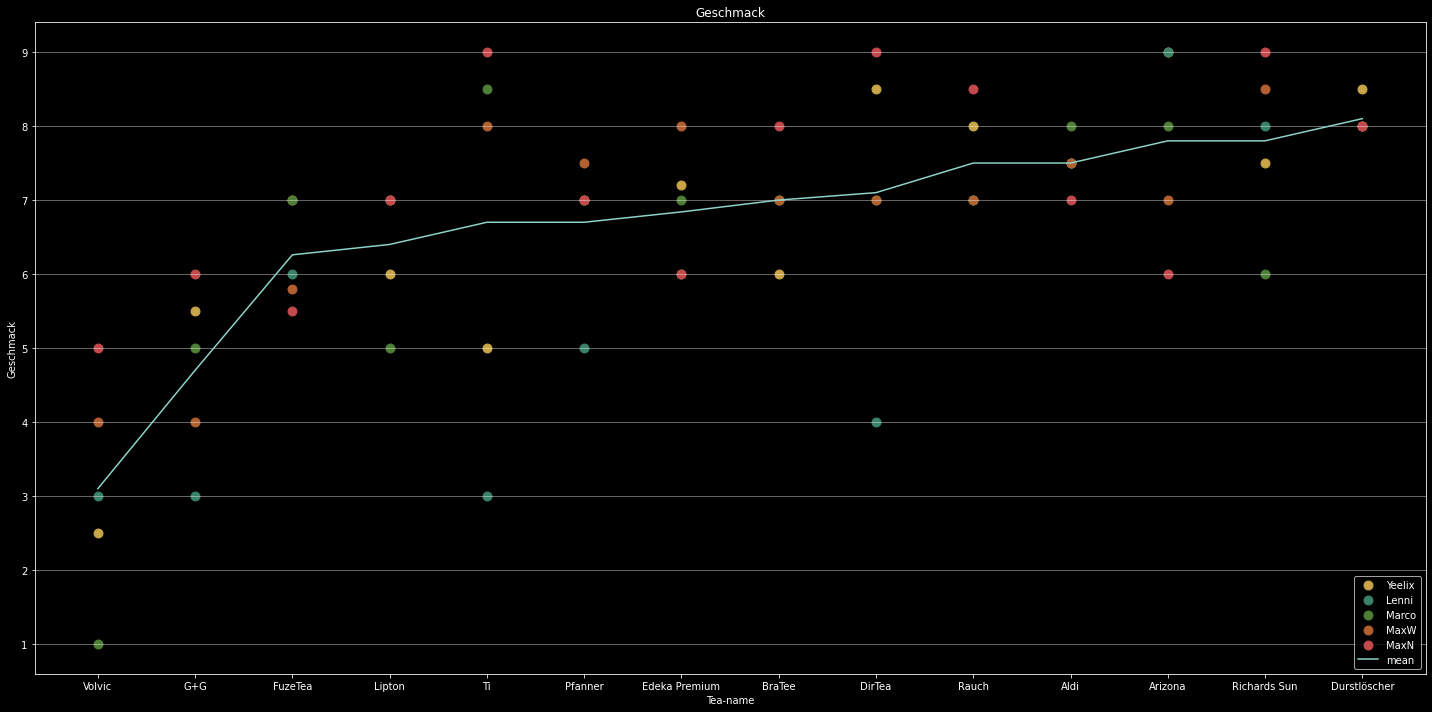

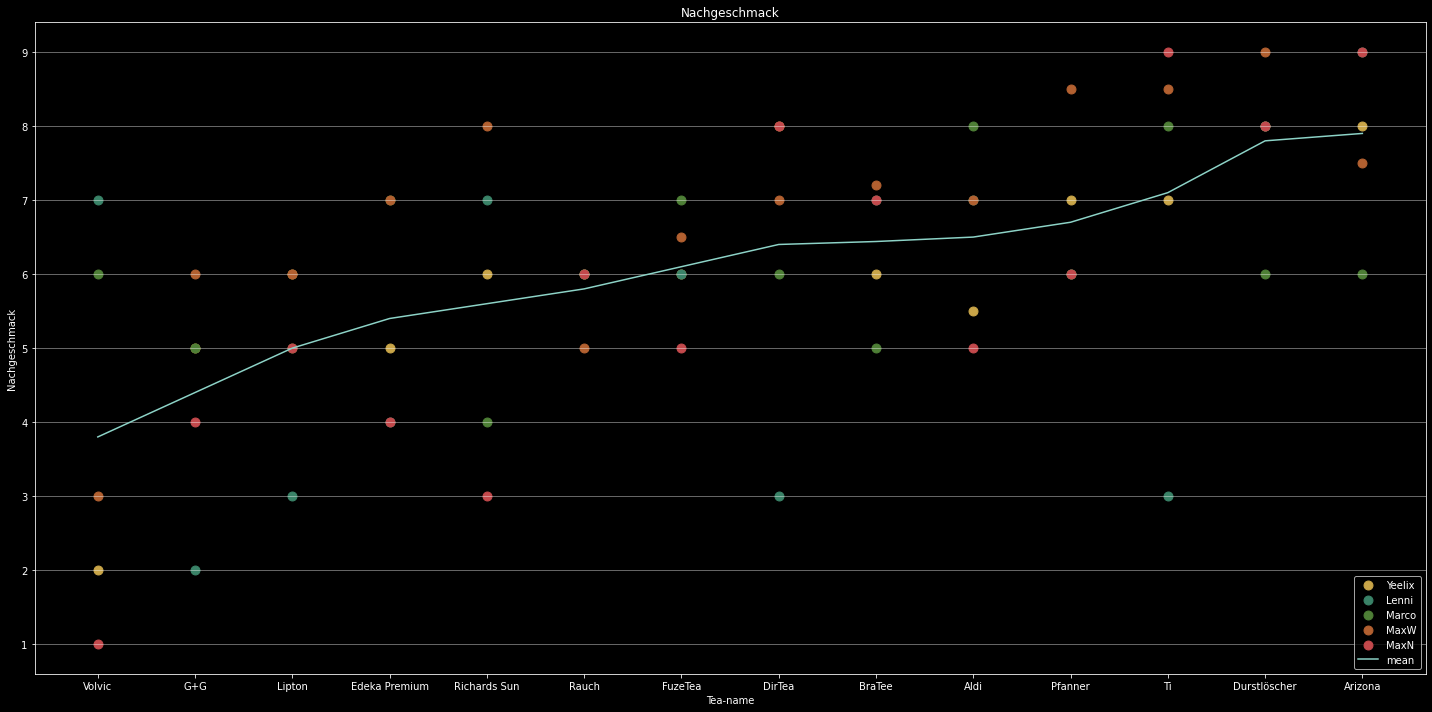

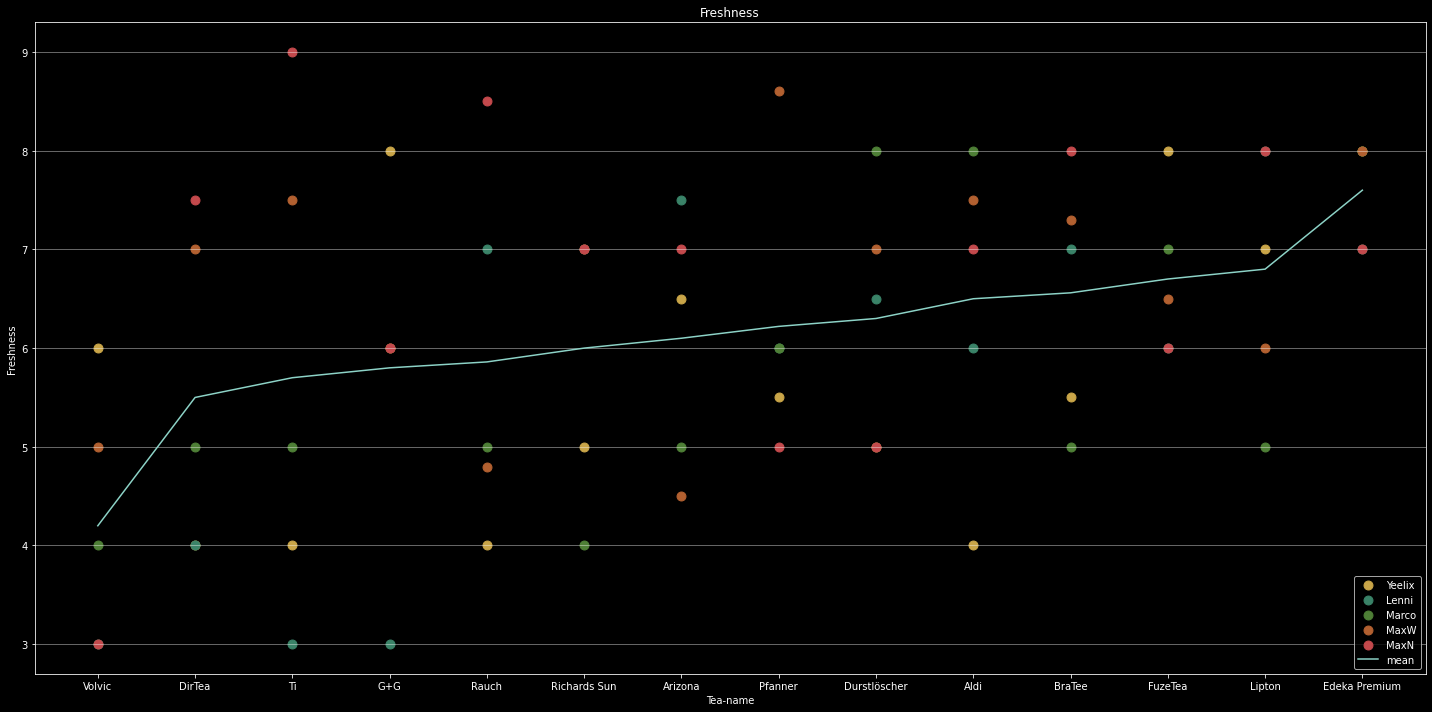

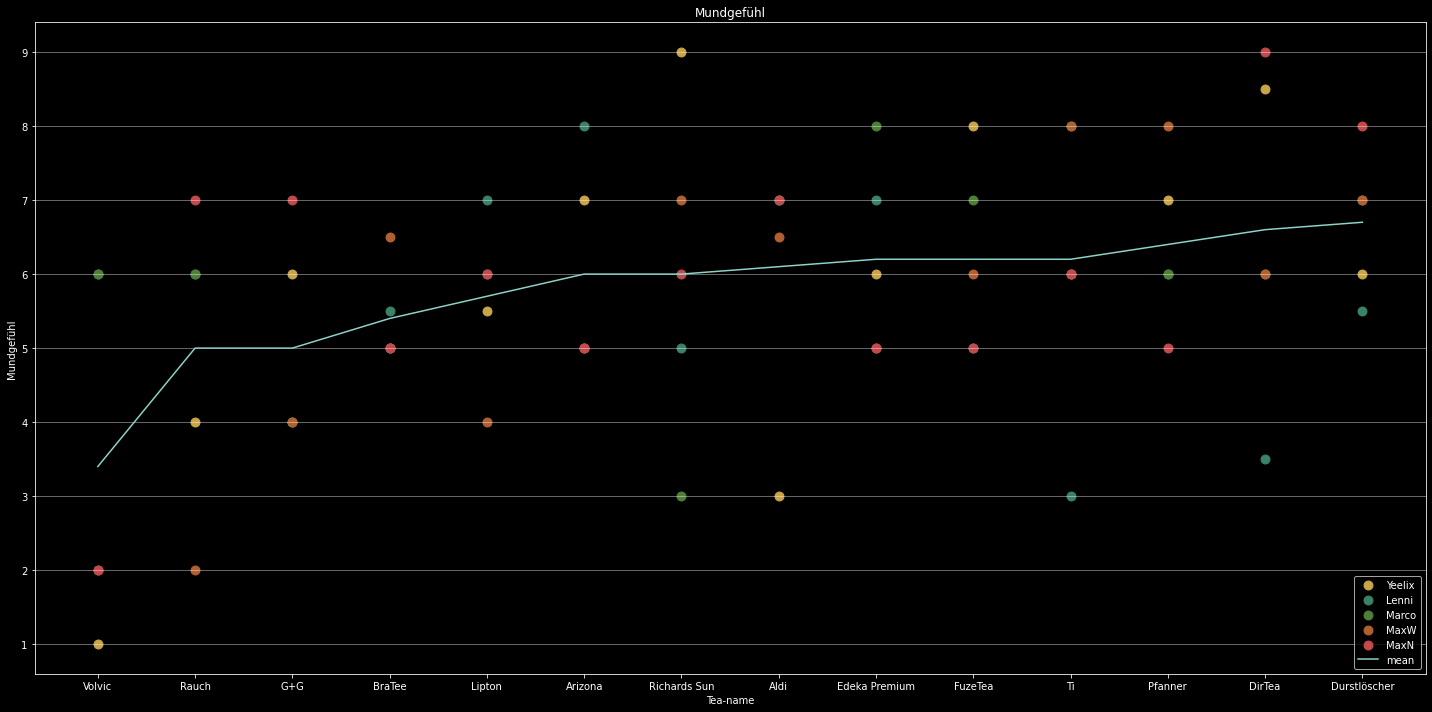

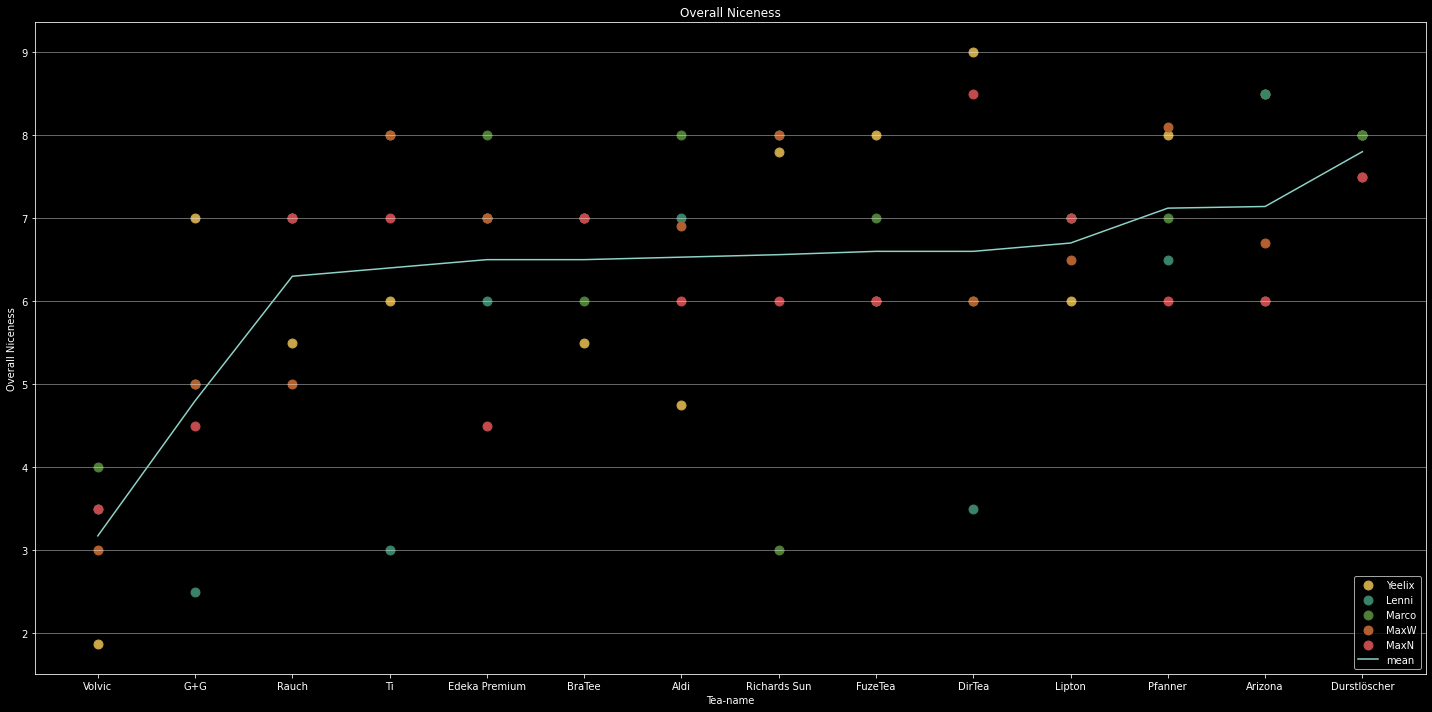

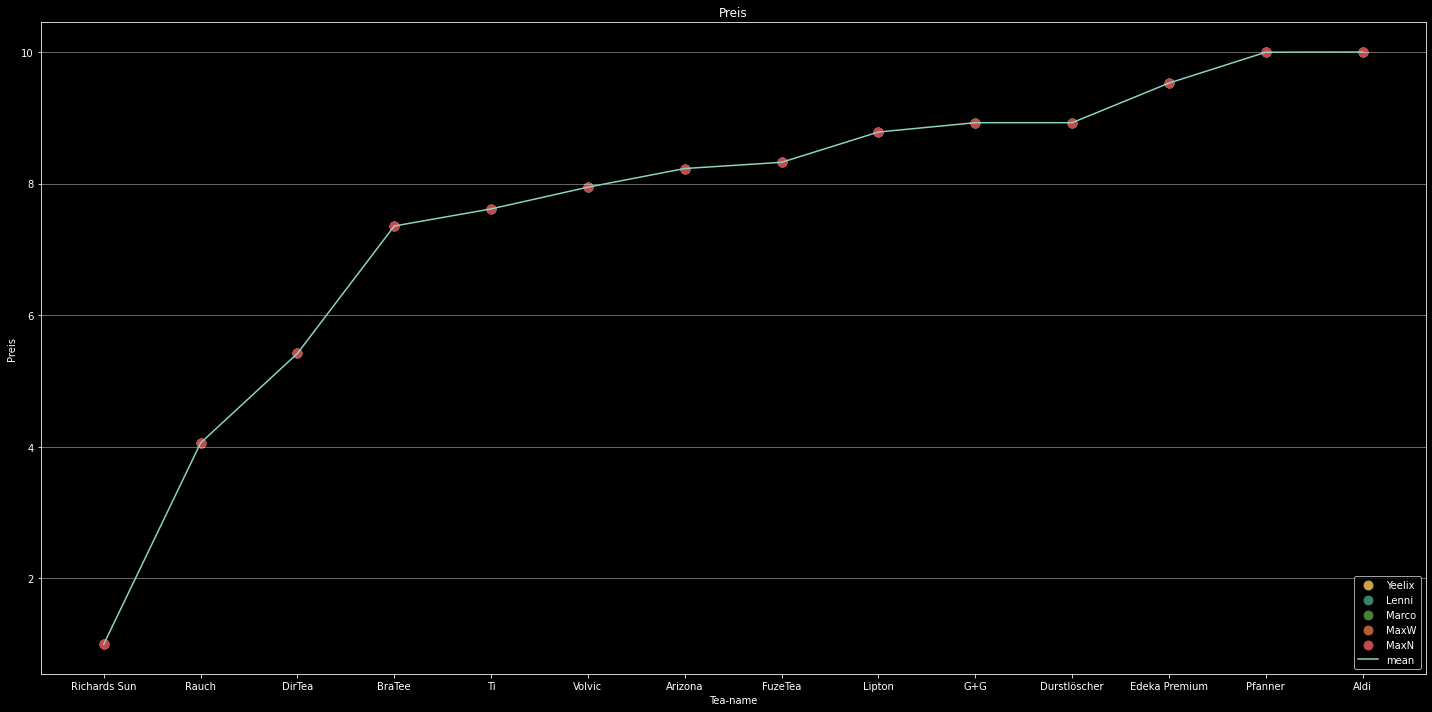

In [48]:

for category in categories:
    # calculate mean of each Tea-ID in the given category
    sorted_names = data.groupby("Tea-ID")[category].agg(mean="mean")
    sorted_names = sorted_names.join(labels.set_index("Tea-ID"), "Tea-ID", how="inner").sort_values("mean")

    data["Tea-name"] = pd.Categorical(data["Name"], sorted_names["Name"])
    data.sort_values(by="Tea-name", inplace=True)
    fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(20, 10))

    # ax = fig.add_subplot(1, 1, 1)
    for judge, color in zip(judges, judges_colors):
        data_judge = data[data["Tester"] == judge]
        data_judge.plot.scatter(x="Tea-name", y=category, c=color, label=judge, cmap="tab20b", ax=axs, s=80)


    sorted_names["Tea-name"] = pd.Categorical(sorted_names["Name"], sorted_names["Name"])
    sorted_names.plot(x="Tea-name", y="mean", ax=axs)


    # axs.set_xticks(range(1, len(teas)+1))
    # axs.set_xticklabels(teas, rotation='vertical', fontsize=18)
    axs.grid(alpha=0.5, axis="y")

    axs.set_title(category)

    axs.legend(loc="lower right")

    #fig.show()
    fig.savefig(plotPath / f"{category}_plot.png")


In [49]:
aggregate_dict = dict([(c, ["mean"]) for c in categories])
means = data.groupby("Tea-ID").agg(aggregate_dict)

aggregate_dict_2 = dict([((c, "mean"), ["mean"]) for c in categories])
average_icetea = means.agg(aggregate_dict_2)
average_values = average_icetea.loc["mean"].to_list()
print(average_values)

[6.678571428571428, 6.067142857142857, 6.131428571428572, 5.778571428571429, 6.33742857142857, 7.579147644032571]


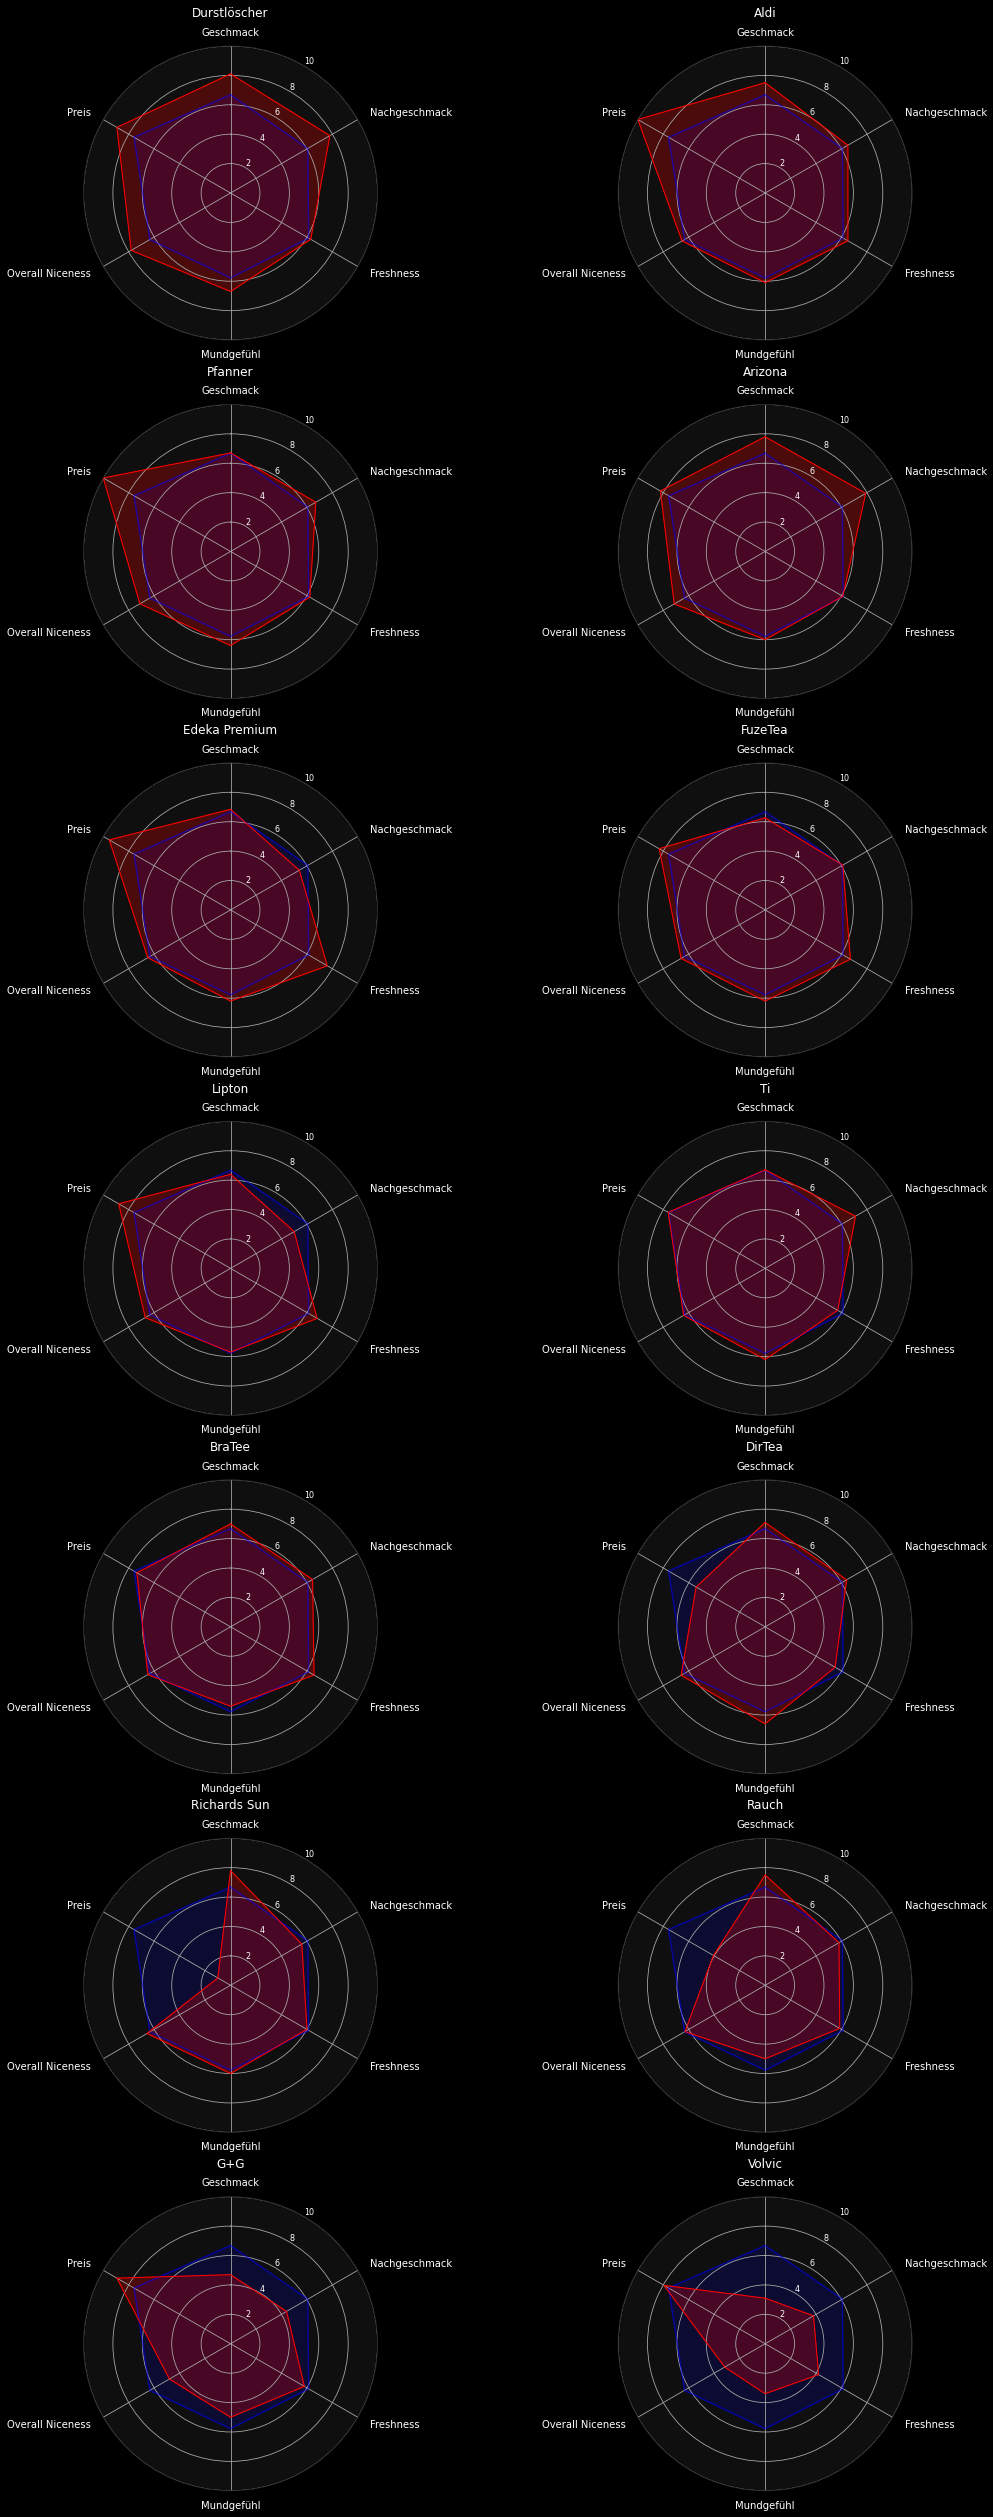

In [51]:
def radar_plot(values, labels, ax, cmp_values=None, title=""):
    ## Radar Plots
    # https://www.pythoncharts.com/matplotlib/radar-charts/

    n_categories = len(labels)
    angles = np.linspace(0, 2*np.pi, n_categories, endpoint=False)

    # append first value to close the circle
    angles = np.append(angles, 0.)
    values = np.append(values, values[0])

    if cmp_values:
        cmp_values = np.append(cmp_values, cmp_values[0])

        ax.plot(angles, cmp_values, color='blue', alpha=0.5)
        ax.fill(angles, cmp_values, color='blue', alpha=0.15)
    # Draw the outline of our data.
    ax.plot(angles, values, color='red', linewidth=1)
    # Fill it in.
    ax.fill(angles, values, color='red', alpha=0.25)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
      if angle in (0, np.pi):
        label.set_horizontalalignment('center')
      elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
      else:
        label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 10)
    # You can also set gridlines manually like this:
    # ax.set_rgrids([20, 40, 60, 80, 100])

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / n_categories)

    # Add some custom styling.

    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA10')

    # Lastly, give the chart a title and give it some
    # padding above the "Acceleration" label.
    ax.set_title(title, y=1.08)


fig, axs = plt.subplots(7, 2, figsize=(3*5, 7*5), subplot_kw=dict(polar=True))
def tea_sorter(x):
  vals = means.loc[x]
  sq = np.square(vals)
  mean = np.sum(sq)/len(sq)
  return np.sqrt(mean)
#forbidden sorting technique
tea_ids = sorted(range(1, len(teas)+1), key=tea_sorter, reverse=True)
# tea_ids = sorted(range(1, len(teas)+1), key=lambda x: means.loc[x].sum(), reverse=True)

for tea_id, ax in zip(tea_ids, axs.flatten()):
    
    title = teas[tea_id-1]
    values = means.loc[tea_id].to_list()
    # values.append(data.loc[tea_id]["Preis"])
    radar_plot(values, categories, ax, title=title, cmp_values=average_values)

fig.tight_layout()
fig.savefig(plotPath / "radar_plots.png")
    

    

# Haben die Eistee-zutaten einen Einfluss auf seine Rezeption?
### Hypothese: Je Zucker desto nice
